In [25]:
import pandas as pd
import seaborn as sns
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
sns.set_context("notebook", font_scale=1.25)

In [26]:
def parse_gtime(filename):
    """
    Parses a gtime output file to extract elapsed time and maximum memory usage.

    Args:
        filename (str): Path to the gtime output file.

    Returns:
        tuple: A tuple containing:
               - time (str): Elapsed wall clock time in the format "h:mm:ss" or "m:ss".
               - memory (int): Maximum resident set size in kilobytes.
    """

    def convert_to_seconds(time_str):
        """
        Converts a time string in the format "h:mm:ss" or "m:ss" to seconds.
    
        Args:
            time_str (str): Time string in "h:mm:ss" or "m:ss" format.
    
        Returns:
            float: Time in seconds.
        """
        parts = time_str.split(":")
        if len(parts) == 3:  # Format: h:mm:ss
            hours, minutes, seconds = map(float, parts)
            return hours * 3600 + minutes * 60 + seconds
        elif len(parts) == 2:  # Format: m:ss
            minutes, seconds = map(float, parts)
            return minutes * 60 + seconds
        elif len(parts) == 1: # just seconds
            return float(parts[0])
        else:
            raise ValueError(f"Unrecognized time format: {time_str}")
            
    time = None
    memory = None

    with open(filename, 'r') as file:
        for line in file:
            # Extract elapsed time
            if line.strip().startswith("Elapsed (wall clock) time"):
                time_str = line.strip().strip("Elapsed (wall clock) time (h:mm:ss or m:ss):")
                time = convert_to_seconds(time_str)

            # Extract maximum memory usage
            if line.strip().startswith("Maximum resident set size"):
                memory = int(line.split(":")[-1].strip())

    return time, memory

In [27]:
def extract_matrices(input_file):
    """
    Extracts variant read count matrix (V) and total read count matrix (D) from a TSV file.

    Args:
        input_file (str): Path to the input TSV file.

    Returns:
        tuple: A tuple containing:
               - V (numpy.ndarray): A 2D array of variant read counts (samples x mutations).
               - D (numpy.ndarray): A 2D array of total read counts (samples x mutations).
    """
    # Read the TSV file into a DataFrame
    df = pd.read_csv(input_file, sep='\t')

    # Sort the DataFrame by sample_index and mutation_index
    df = df.sort_values(by=['sample_index', 'mutation_index'])

    # Pivot the DataFrame to create matrices
    V = df.pivot(index='sample_index', columns='mutation_index', values='var').values
    D = df.pivot(index='sample_index', columns='mutation_index', values='depth').values

    return V, D

In [28]:
def extract_frequency_matrix(input_file):
    """
    Extracts the frequency matrix (F) from a TSV file, ensuring frequency columns are sorted correctly.

    Args:
        input_file (str): Path to the input TSV file.

    Returns:
        numpy.ndarray: A 2D array of frequencies (samples x mutations).
    """
    # Read the TSV file into a DataFrame
    df = pd.read_csv(input_file, sep='\t')

    # Extract columns starting with 'f_'
    f_columns = [col for col in df.columns if col.startswith('f_')]

    # Sort frequency columns in the correct order
    f_columns_sorted = sorted(f_columns, key=lambda x: (int(x.split('_')[1]), int(x.split('_')[2])))

    # Extract the sorted frequency columns
    F = df[f_columns_sorted].values

    # Reshape the frequency matrix to (samples x mutations)
    num_samples = max(int(col.split('_')[1]) for col in f_columns_sorted) + 1
    num_mutations = max(int(col.split('_')[2]) for col in f_columns_sorted) + 1
    F = F.reshape(-1, num_samples, num_mutations)

    # Take the first row
    F = F[0]

    return F

In [29]:
def extract_number_trees(input_file):
    """
    Extracts the number of trees

    Args:
        input_file (str): Path to the input TSV file.

    Returns:
        int: Number of trees.
    """
    # Read the TSV file into a DataFrame
    df = pd.read_csv(input_file, sep='\t')
    return df.shape[0]

In [6]:
def binomial_log_likelihood(F, V, D, eps=1e-10):
    """
    Computes the binomial log-likelihood given frequency, variant, and total read count matrices.

    Args:
        F (numpy.ndarray): Frequency matrix (samples x mutations).
        V (numpy.ndarray): Variant read count matrix (samples x mutations).
        D (numpy.ndarray): Total read count matrix (samples x mutations).
        eps (float): A small value to avoid log(0). Default is 1e-10.

    Returns:
        float: The binomial log-likelihood.
    """
    # Ensure F is within valid range [0, 1]
    F = np.clip(F, eps, 1 - eps)

    # Compute the log-likelihood
    log_likelihood = np.sum(
        np.where(V > 0, V * np.log(F), 0) +  # Handle V = 0
        np.where(D - V > 0, (D - V) * np.log(1 - F), 0)  # Handle D - V = 0
    )

    return log_likelihood

In [30]:
def determine_gt_trees():
    d = {n : {} for n in [20,50]}
    for n in [20,50]:
        for s in range(1,21):
            for filename in glob.glob("../data/sims/n%d_m10_s%d.tree" % (n,s)):
                with open(filename, "r") as f:
                    line = f.readline()
                    ss = line.rstrip("))").split("),")
                    ss = [sss[2:].split(', ') for sss in ss]
                    sset = set()
                    for l in ss:
                        sset.add((int(l[0]),int(l[1])))
                    d[n][s] = sset

    return d
    
gt_trees = determine_gt_trees()

In [94]:
import itertools

def get_ancestor_sets(ad_pairs):
    """
    Converts a list of (ancestor, descendant) pairs into a dictionary 
    mapping every node to its set of ancestors (including itself).
    """
    # 1. Identify all unique nodes
    nodes = set()
    for anc, desc in ad_pairs:
        nodes.add(anc)
        nodes.add(desc)
        
    # 2. Build adjacency graph (child -> parents)
    # Note: In a tree, a node has 1 parent, but we use a set for general DAG safety
    parents_of = {n: set() for n in nodes}
    for anc, desc in ad_pairs:
        parents_of[desc].add(anc)
        
    # 3. Compute transitive closure (full ancestry) via memoization
    # We want A(u) = {u} U {A(p) for p in parents(u)}
    ancestors_map = {}

    def get_ancestors(node):
        if node in ancestors_map:
            return ancestors_map[node]
        
        # Start with the node itself (reflexive property)
        ancs = {node}
        for parent in parents_of[node]:
            # Recursively add parents' ancestors
            ancs.update(get_ancestors(parent))
            
        ancestors_map[node] = ancs
        return ancs

    for n in nodes:
        get_ancestors(n)
        
    return ancestors_map, nodes

def jaccard_distance(set1, set2):
    """Computes 1 - (Intersection / Union)."""
    union_len = len(set1.union(set2))
    if union_len == 0:
        return 0.0
    intersection_len = len(set1.intersection(set2))
    return 1.0 - (intersection_len / union_len)

def compute_caset_distance(pairs1, pairs2):
    """
    Computes CASet distance between two trees defined by lists of pairs.
    
    Args:
        pairs1: List of tuples (ancestor, descendant) for Tree 1
        pairs2: List of tuples (ancestor, descendant) for Tree 2
        
    Returns:
        float: The CASet distance
    """
    # 1. Build Ancestor Maps: node -> {set of all ancestors}
    anc_map_1, nodes_1 = get_ancestor_sets(pairs1)
    anc_map_2, nodes_2 = get_ancestor_sets(pairs2)
    
    # 2. Define the universe of mutations (usually intersection, but union is safer for disparate trees)
    # Standard metric assumes trees share the same label set.
    all_nodes = list(nodes_1.union(nodes_2))
    n = len(all_nodes)
    
    if n < 2:
        return 0.0
    
    total_distance = 0.0
    pair_count = 0
    
    # 3. Iterate over all unique pairs of mutations {u, v}
    for u, v in itertools.combinations(all_nodes, 2):
        
        # Get Ancestor sets for u and v in Tree 1
        # Handle cases where a node might not exist in one tree (default to empty set)
        A_u_1 = anc_map_1.get(u, set())
        A_v_1 = anc_map_1.get(v, set())
        
        # Common Ancestor Set for (u, v) in Tree 1 = Intersection of their ancestors
        CAS_1 = A_u_1.intersection(A_v_1)
        
        # Repeat for Tree 2
        A_u_2 = anc_map_2.get(u, set())
        A_v_2 = anc_map_2.get(v, set())
        CAS_2 = A_u_2.intersection(A_v_2)
        
        # 4. Compute Jaccard distance between the two Common Ancestor Sets
        dist = jaccard_distance(CAS_1, CAS_2)
        
        total_distance += dist
        pair_count += 1
        
    # 5. Average the distance
    return total_distance / pair_count

# # --- Example Usage ---
# if __name__ == "__main__":
#     # Tree 1: Linear 1 -> 2 -> 3
#     # Pairs provided might be transitive or just edges
#     tree1_pairs = [(1, 2), (2, 3)] 
    
#     # Tree 2: Branching 1 -> 2, 1 -> 3 (2 and 3 are siblings)
#     tree2_pairs = [(1, 2), (1, 3)]
    
#     distance = compute_caset_distance(tree1_pairs, tree2_pairs)
    
#     print(f"CASet Distance: {distance:.4f}")
    
#     # Explanation of calculation for Pair (2, 3):
#     # T1: Anc(2)={1,2}, Anc(3)={1,2,3}. Common={1,2}
#     # T2: Anc(2)={1,2}, Anc(3)={1,3}.   Common={1}
#     # Jaccard({1,2}, {1}) = 1 - (1/2) = 0.5
#     # Other pairs (1,2) and (1,3) likely have distance 0.

In [98]:
def compute_disc_distance(pairs1, pairs2):
    """
    Computes DISC distance between two trees.
    """
    # 1. Build Ancestor Maps
    anc_map_1, nodes_1 = get_ancestor_sets(pairs1)
    anc_map_2, nodes_2 = get_ancestor_sets(pairs2)
    
    # 2. Define Universe
    all_nodes = list(nodes_1.union(nodes_2))
    n_nodes = len(all_nodes)
    
    if n_nodes < 2:
        return 0.0
    
    total_distance = 0.0
    pair_count = 0
    
    # 3. Iterate over all unique pairs
    for u, v in itertools.combinations(all_nodes, 2):
        
        # Tree 1: Symmetric Difference of ancestors
        A_u_1 = anc_map_1.get(u, set())
        A_v_1 = anc_map_1.get(v, set())
        # The ^ operator is Python's shorthand for symmetric_difference
        DIS_1 = A_u_1 ^ A_v_1 
        
        # Tree 2: Symmetric Difference of ancestors
        A_u_2 = anc_map_2.get(u, set())
        A_v_2 = anc_map_2.get(v, set())
        DIS_2 = A_u_2 ^ A_v_2
        
        # 4. Compute Jaccard Distance
        dist = jaccard_distance(DIS_1, DIS_2)
        
        total_distance += dist
        pair_count += 1
        
    return total_distance / pair_count

In [100]:
def extract_inferred_full_trees(gt_trees):
    def transitive_closure(relation):
        elements = {x for pair in relation for x in pair}
        elements = sorted(elements)
        size = len(elements)
        element_to_index = {elem: idx for idx, elem in enumerate(elements)}
        
        # Initialize adjacency matrix
        matrix = [[False] * size for _ in range(size)]
        for a, b in relation:
            i = element_to_index[a]
            j = element_to_index[b]
            matrix[i][j] = True
        
        # Warshall's algorithm
        for k in range(size):
            for i in range(size):
                for j in range(size):
                    matrix[i][j] = matrix[i][j] or (matrix[i][k] and matrix[k][j])
        
        # Convert back to tuples
        result = set()
        for i in range(size):
            for j in range(size):
                if matrix[i][j]:
                    result.add((elements[i], elements[j]))
        
        return result
    
    rows = []
    for n in [20,50]:
        for s in range(1,21):
            ad_gt_tree = transitive_closure(gt_trees[n][s])
            for filename in glob.glob("../data/sims/n%d_m10_s%d.tsv" % (n,s)):
                basename = os.path.basename(filename).rstrip(".tsv")
                for b in [1, 10, 50, 100]:
                    filename = "sims_infer_full_trees_fastppm_small_expand/" + basename + "_b" + str(b) + ".tsv"
                    recall_list = []
                    PC_list = []
                    AD_list = []
                    CASet_list = []
                    DISC_list = []
                    with open(filename, "r") as f:
                        f.readline()
                        for line in f:
                            # line = f.readline()
                            tree = list(zip(list(map(int, line.split("\t")[2:2+n])),range(n)))
                            new_tree = set()
                            for (src, tgt) in tree:
                                if src != -1:
                                    new_tree.add((src, tgt))
                            ad_new_tree = transitive_closure(new_tree)
                            PC = len(set.symmetric_difference(gt_trees[n][s], new_tree)) / len(set.union(gt_trees[n][s], new_tree))
                            AD = len(set.symmetric_difference(ad_gt_tree, ad_new_tree)) / len(set.union(ad_gt_tree, ad_new_tree))
                            recall = len(set.intersection(gt_trees[n][s], new_tree)) / (n - 1)
                            CASet = compute_caset_distance(gt_trees[n][s], new_tree)
                            DISC = compute_disc_distance(gt_trees[n][s], new_tree)
                            
                            PC_list.append(PC)
                            AD_list.append(AD)
                            recall_list.append(recall)
                            CASet_list.append(CASet)
                            DISC_list.append(DISC)
                            
                        PC = np.min(PC_list)
                        AD = np.min(AD_list)
                        recall = np.max(recall_list)
                        CASet = np.min(CASet_list)
                        DISC = np.min(DISC_list)
                        
                        row = {'n' : n, 'beam-width' : b, 'instance' : basename, 
                               'method' : "sapling-small", 'PC' : PC, 
                               'recall' : recall, 'AD' : AD, 'CASet' : CASet,
                               'DISC' : DISC
                              }
                        rows.append(row)

                    filename = "sims_infer_full_trees_orchard/" + basename + ".ssm_k" + str(b) + ".tsv"
                    recall_list = []
                    PC_list = []
                    AD_list = []
                    CASet_list = []
                    DISC_list = []
                    with open(filename, "r") as f:
                        f.readline()
                        for line in f:
                            # line = f.readline()
                            tree = list(zip(list(map(int, line.split("\t")[2:2+n])),range(n)))
                            new_tree = set()
                            for (src, tgt) in tree:
                                if src != -1:
                                    new_tree.add((src, tgt))
                            # ad_gt_tree = transitive_closure(gt_trees[n][s])
                            ad_new_tree = transitive_closure(new_tree)
                            PC = len(set.symmetric_difference(gt_trees[n][s], new_tree)) / len(set.union(gt_trees[n][s], new_tree))
                            AD = len(set.symmetric_difference(ad_gt_tree, ad_new_tree)) / len(set.union(ad_gt_tree, ad_new_tree))
                            recall = len(set.intersection(gt_trees[n][s], new_tree)) / (n - 1)
                            CASet = compute_caset_distance(gt_trees[n][s], new_tree)
                            DISC = compute_disc_distance(gt_trees[n][s], new_tree)

                            PC_list.append(PC)
                            AD_list.append(AD)
                            recall_list.append(recall)
                            CASet_list.append(CASet)
                            DISC_list.append(DISC)

                        PC = np.min(PC_list)
                        AD = np.min(AD_list)
                        recall = np.max(recall_list)
                        CASet = np.min(CASet_list)
                        DISC = np.min(DISC_list)
                        
                        row = {'n' : n, 'beam-width' : b, 'instance' : basename, 
                               'method' : "orchard", 'PC' : PC, 
                               'recall' : recall, 'AD' : AD, 'CASet' : CASet,
                               'DISC' : DISC
                              }
                        rows.append(row)

                    filename = "sims_infer_full_trees_fastbe/" + basename + "_k" + str(b) + ".tsv"
                    recall_list = []
                    PC_list = []
                    AD_list = []
                    CASet_list = []
                    DISC_list = []
                    with open(filename, "r") as f:
                        f.readline()
                        for line in f:
                            # line = f.readline()
                            tree = list(zip(list(map(int, line.split("\t")[2:2+n])),range(n)))
                            new_tree = set()
                            for (src, tgt) in tree:
                                if src != -1:
                                    new_tree.add((src, tgt))
                            # ad_gt_tree = transitive_closure(gt_trees[n][s])
                            ad_new_tree = transitive_closure(new_tree)
                            PC = len(set.symmetric_difference(gt_trees[n][s], new_tree)) / len(set.union(gt_trees[n][s], new_tree))
                            AD = len(set.symmetric_difference(ad_gt_tree, ad_new_tree)) / len(set.union(ad_gt_tree, ad_new_tree))
                            recall = len(set.intersection(gt_trees[n][s], new_tree)) / (n - 1)
                            CASet = compute_caset_distance(gt_trees[n][s], new_tree)
                            DISC = compute_disc_distance(gt_trees[n][s], new_tree)

                            PC_list.append(PC)
                            AD_list.append(AD)
                            recall_list.append(recall)
                            CASet_list.append(CASet)
                            DISC_list.append(DISC)

                        PC = np.min(PC_list)
                        AD = np.min(AD_list)
                        recall = np.max(recall_list)
                        CASet = np.min(CASet_list)
                        DISC = np.min(DISC_list)
                        
                        row = {'n' : n, 'beam-width' : b, 'instance' : basename, 
                               'method' : "fastbe", 'PC' : PC, 
                               'recall' : recall, 'AD' : AD, 'CASet' : CASet,
                               'DISC' : DISC
                              }
                        rows.append(row)

                    
    return rows
    
df_full_trees_PC = pd.DataFrame(extract_inferred_full_trees(gt_trees))

In [32]:
# handle infer_full_trees experiments
rows = []
for n in [20,50,100]:
    for filename in glob.glob("../data/sims/n%d*.tsv" % n):
        V, D = extract_matrices(filename)
        basename = os.path.basename(filename).rstrip(".tsv")
    
        for b in [1, 10, 50, 100]:
            # F = extract_frequency_matrix("sims_infer_full_trees_fastppm_big_expand2/" + basename + "_b" + str(b) + ".tsv")
            # llh = binomial_log_likelihood(F, V, D)
            # nr_trees = extract_number_trees("sims_infer_full_trees_fastppm_big_expand2/" + basename + "_b" + str(b) + ".tsv")
            # time, memory = parse_gtime("sims_infer_full_trees_fastppm_big_expand2/" + basename + "_b" + str(b) + ".time")
            # row = {'n' : n, 'trees' : nr_trees, 'beam-width' : b, 'instance' : basename, 'llh' : llh, 'method' : "sapling-big", 'time' : time, 'memory' : memory}
            # rows.append(row)
    
            F = extract_frequency_matrix("sims_infer_full_trees_fastppm_small_expand/" + basename + "_b" + str(b) + ".tsv")
            llh = binomial_log_likelihood(F, V, D)
            nr_trees = extract_number_trees("sims_infer_full_trees_fastppm_small_expand/" + basename + "_b" + str(b) + ".tsv")
            time, memory = parse_gtime("sims_infer_full_trees_fastppm_small_expand/" + basename + "_b" + str(b) + ".time")
            row = {'n' : n, 'trees' : nr_trees, 'beam-width' : b, 'instance' : basename, 'llh' : llh, 'method' : "sapling-small", 'time' : time, 'memory' : memory}
            rows.append(row)
    
            F = extract_frequency_matrix("sims_infer_full_trees_orchard/" + basename + ".ssm_k" + str(b) + ".tsv")
            llh = binomial_log_likelihood(F, V, D)
            nr_trees = extract_number_trees("sims_infer_full_trees_orchard/" + basename + ".ssm_k" + str(b) + ".tsv")
            time, memory = parse_gtime("sims_infer_full_trees_orchard/" + basename + ".ssm_k" + str(b) + ".time")
            row = {'n' : n, 'trees' : nr_trees, 'beam-width' : b, 'instance' : basename, 'llh' : llh, 'method' : "orchard", 'time' : time, 'memory' : memory}
            rows.append(row)

            F = extract_frequency_matrix("sims_infer_full_trees_fastbe/" + basename + "_k" + str(b) + ".tsv")
            llh = binomial_log_likelihood(F, V, D)
            nr_trees = extract_number_trees("sims_infer_full_trees_fastbe/" + basename + "_k" + str(b) + ".tsv")
            time, memory = parse_gtime("sims_infer_full_trees_fastbe/" + basename + "_k" + str(b) + ".time")
            row = {'n' : n, 'trees' : nr_trees, 'beam-width' : b, 'instance' : basename, 'llh' : llh, 'method' : "fastbe", 'time' : time, 'memory' : memory}
            rows.append(row)

df_full_trees = pd.DataFrame(rows)

In [33]:
df_full_trees[df_full_trees['method'] == 'fastbe']

,n,trees,beam-width,instance,llh,method,time,memory
2,20,1,1,n20_m10_s5,-6004.264429,fastbe,0.02,3056
5,20,1,10,n20_m10_s5,-6004.264429,fastbe,0.11,3504
8,20,1,50,n20_m10_s5,-6004.264429,fastbe,0.43,5312
11,20,1,100,n20_m10_s5,-6004.264429,fastbe,0.85,7392
14,20,1,1,n20_m10_s4,-5037.772460,fastbe,0.02,3120
...,...,...,...,...,...,...,...,...
707,100,1,100,n100_m10_s3,-13223.607688,fastbe,32.67,29088
710,100,1,1,n100_m10_s17,-14992.664551,fastbe,0.39,5616
713,100,1,10,n100_m10_s17,-14940.446669,fastbe,3.75,7760
716,100,1,50,n100_m10_s17,-14937.563610,fastbe,18.55,19344


In [12]:
df_full_trees.to_csv("sims_infer_full_trees.csv")

In [13]:
df_full_trees

,n,trees,beam-width,instance,llh,method,time,memory
0,20,1,1,n20_m10_s5,-5999.321612,sapling-small,0.43,74576
1,20,1,1,n20_m10_s5,-6007.779159,orchard,1.55,104656
2,20,1,1,n20_m10_s5,-6004.264429,fastbe,0.02,3056
3,20,10,10,n20_m10_s5,-5999.321612,sapling-small,2.07,88080
4,20,10,10,n20_m10_s5,-6005.337910,orchard,3.83,105696
...,...,...,...,...,...,...,...,...
715,100,50,50,n100_m10_s17,-14883.139691,orchard,313.13,124848
716,100,1,50,n100_m10_s17,-14937.563610,fastbe,18.55,19344
717,100,100,100,n100_m10_s17,-14805.573894,sapling-small,2894.49,2466208
718,100,100,100,n100_m10_s17,-14865.351164,orchard,636.26,158608


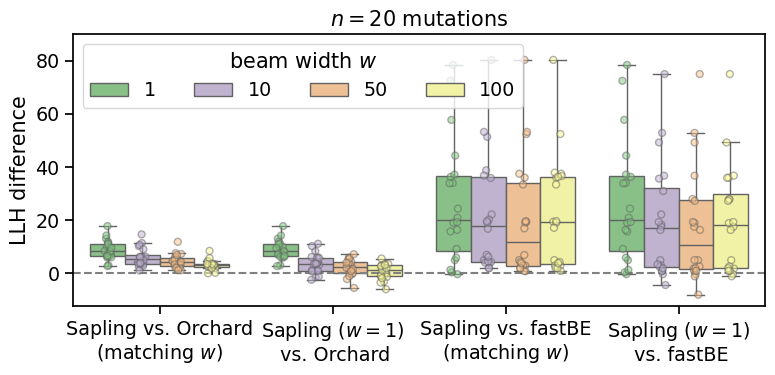

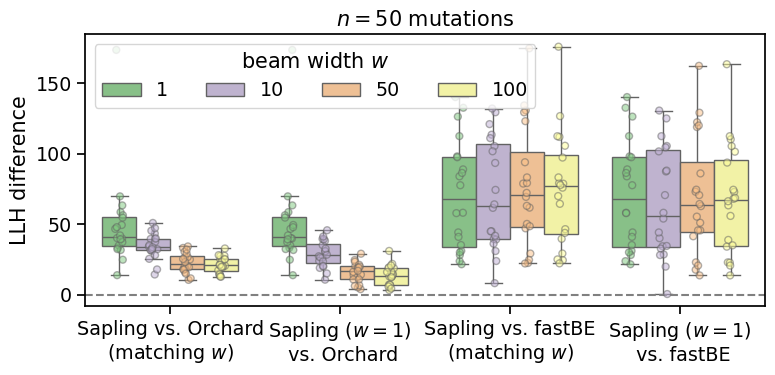

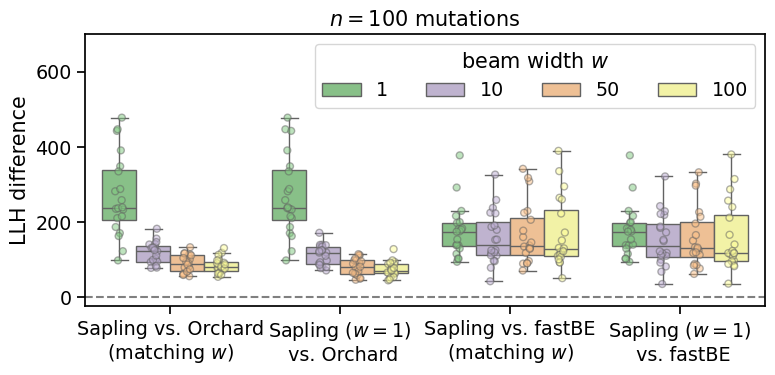

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
for n in [20, 50, 100]:
    # Filter the dataframe for the current value of n
    df = df_full_trees[(df_full_trees["n"] == n)]
    
    # ---- Sapling vs Orchard ----
    # Step 1: Filter rows where method is 'sapling-small' and beam-width == 1
    sapling_small_beam1 = df[(df['method'] == 'sapling-small') & (df['beam-width'] == 1)]
    
    # Step 2: Filter rows where method is 'orchard'
    orchard_methods = df[df['method'] == 'orchard']
    
    # Step 3: Merge the two dataframes on 'instance' for the first comparison
    merged_beam1_vs_orchard = pd.merge(
        sapling_small_beam1[['instance', 'llh']],
        orchard_methods[['instance', 'beam-width', 'llh']],
        on='instance',
        suffixes=('_sapling_small_beam1', '_orchard')
    )
    
    # Step 4: Compute the llh difference for the first comparison
    merged_beam1_vs_orchard['llh_diff'] = (
        merged_beam1_vs_orchard['llh_sapling_small_beam1'] -
        merged_beam1_vs_orchard['llh_orchard']
    )
    merged_beam1_vs_orchard['comparison'] = 'Sapling ($w=1$)\n vs. Orchard'
    
    # Step 5: Compare sapling-small vs. orchard with matching beamwidths
    sapling_small_all_beamwidths = df[df['method'] == 'sapling-small']
    orchard_all_beamwidths = df[df['method'] == 'orchard']
    
    merged_matching_beamwidths_orchard = pd.merge(
        sapling_small_all_beamwidths[['instance', 'beam-width', 'llh']],
        orchard_all_beamwidths[['instance', 'beam-width', 'llh']],
        on=['instance', 'beam-width'],
        suffixes=('_sapling_small', '_orchard')
    )
    
    merged_matching_beamwidths_orchard['llh_diff'] = (
        merged_matching_beamwidths_orchard['llh_sapling_small'] -
        merged_matching_beamwidths_orchard['llh_orchard']
    )
    merged_matching_beamwidths_orchard['comparison'] = 'Sapling vs. Orchard\n(matching $w$)'
    
    # ---- Sapling vs fastBE ----
    fastbe_methods = df[df['method'] == 'fastbe']
    
    # Sapling (w=1) vs fastBE (all k / beam-widths)
    merged_beam1_vs_fastbe = pd.merge(
        sapling_small_beam1[['instance', 'llh']],
        fastbe_methods[['instance', 'beam-width', 'llh']],
        on='instance',
        suffixes=('_sapling_small_beam1', '_fastbe')
    )
    merged_beam1_vs_fastbe['llh_diff'] = (
        merged_beam1_vs_fastbe['llh_sapling_small_beam1'] -
        merged_beam1_vs_fastbe['llh_fastbe']
    )
    merged_beam1_vs_fastbe['comparison'] = 'Sapling ($w=1$)\n vs. fastBE'
    
    # Sapling vs fastBE with matching beam-widths
    fastbe_all_beamwidths = fastbe_methods
    
    merged_matching_beamwidths_fastbe = pd.merge(
        sapling_small_all_beamwidths[['instance', 'beam-width', 'llh']],
        fastbe_all_beamwidths[['instance', 'beam-width', 'llh']],
        on=['instance', 'beam-width'],
        suffixes=('_sapling_small', '_fastbe')
    )
    merged_matching_beamwidths_fastbe['llh_diff'] = (
        merged_matching_beamwidths_fastbe['llh_sapling_small'] -
        merged_matching_beamwidths_fastbe['llh_fastbe']
    )
    merged_matching_beamwidths_fastbe['comparison'] = 'Sapling vs. fastBE\n(matching $w$)'
    
    # ---- Combine all four comparisons ----
    combined = pd.concat(
        [
            merged_matching_beamwidths_orchard,
            merged_beam1_vs_orchard,
            merged_matching_beamwidths_fastbe,
            merged_beam1_vs_fastbe,
        ],
        ignore_index=True
    )
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 4))
    
    sns.boxplot(
        data=combined,
        ax=ax,
        x="comparison",
        y='llh_diff',
        hue='beam-width',
        showfliers=False,
        palette="Accent"
    )
    sns.stripplot(
        data=combined,
        ax=ax,
        x="comparison",
        y='llh_diff',
        hue='beam-width',
        dodge=True,
        alpha=.5,
        linewidth=1,
        palette="Accent"
    )
    
    plt.xlabel('')
    plt.ylabel('LLH difference')
    plt.title(f'$n = {n}$ mutations')
    plt.axhline(y=0, linestyle='--', color='gray')
    
    # Fix duplicate legend entries from boxplot + stripplot
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(
        handles[:len(labels)//2],
        labels[:len(labels)//2],
        title='beam width $w$',
        ncols=4
    )
    
    if n == 20:
        ax.set_ylim((None, 90))
    elif n == 100:
        ax.set_ylim((None, 700))
    
    plt.tight_layout()
    plt.savefig(f"LLH_Sapling_vs_Orchard_FastBE_Combined_n{n}.pdf")
    # plt.close()

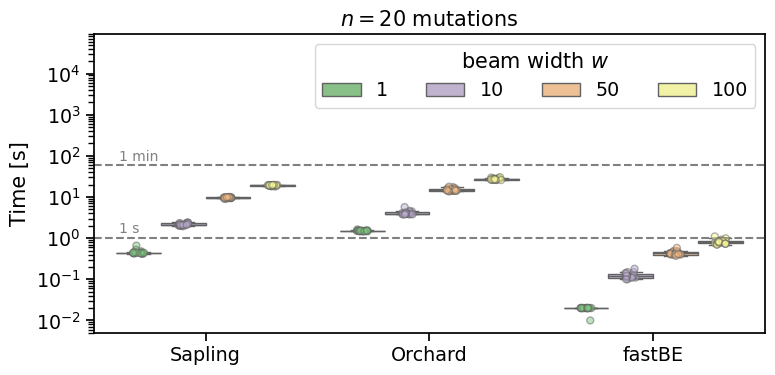

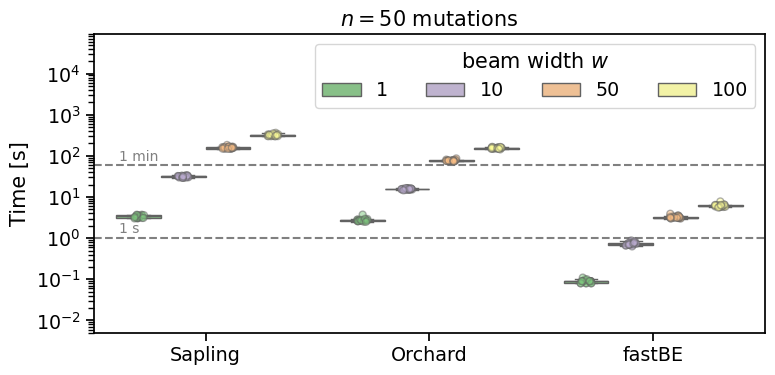

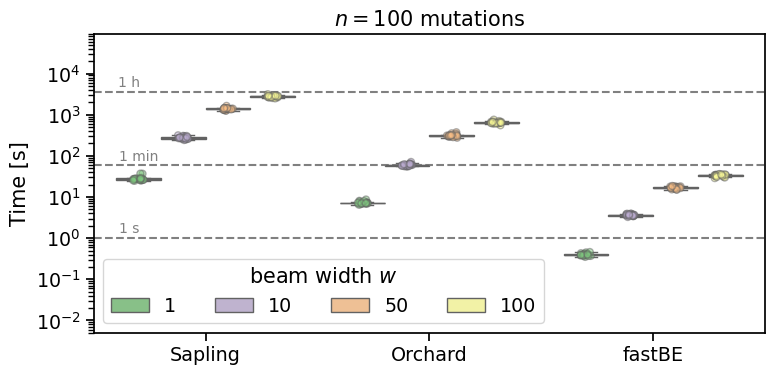

In [34]:
for n in [20,50,100]:
    df_filtered = df_full_trees[(df_full_trees['n'] == n) & (df_full_trees['method'].isin(['sapling-small', 'orchard', 'fastbe']))]
    df_filtered = df_filtered.replace(
        {'method': {'sapling-small': 'Sapling', 'sapling-big' : 'Sapling (big)', 'orchard': 'Orchard', 'fastbe': 'fastBE'}}
    )

    fig, ax = plt.subplots(figsize=(8, 4))
    
    sns.boxplot(data=df_filtered, ax=ax, x='method', y='time', hue='beam-width', showfliers=False, palette="Accent")
    sns.stripplot(data=df_filtered, ax=ax, x='method', y='time', hue='beam-width', palette="Accent",
                  dodge=True, alpha=.5, linewidth=1)
    
    # Add labels and title
    ax.set_xlabel('')
    ax.set_ylabel('Time [s]')
    ax.set_title('$n = %d$ mutations' % n)
    ax.set_yscale('log')  
    ax.set_ylim((5e-3, 9e4))

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[:len(labels)//2], labels[:len(labels)//2], title='beam width $w$', ncols=4)
    plt.axhline(y=1, color='gray', linestyle='--')
    plt.text(x=-.34, y=1.1, s='1 s', color='gray', ha='center', va='bottom',fontsize='10')
    plt.axhline(y=60, color='gray', linestyle='--')
    plt.text(x=-.3, y=65.1, s='1 min', color='gray', ha='center', va='bottom',fontsize='10')

    if n==100:
        plt.axhline(y=3600, color='gray', linestyle='--')
        plt.text(x=-0.34, y=4000, s='1 h', color='gray', ha='center', va='bottom',fontsize='10')
    
    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig("time_full_trees_n%d.pdf" % n)

In [37]:
np.median(df_full_trees[(df_full_trees['method'] == 'fastbe') & (df_full_trees['n'] == 100) & (df_full_trees['beam-width'] == 100)].time)

np.float64(33.74)

In [290]:
np.median(df_full_trees[(df_full_trees['method'] == 'sapling-small') & (df_full_trees['n'] == 100) & (df_full_trees['beam-width'] == 1)].time)

np.float64(27.494999999999997)

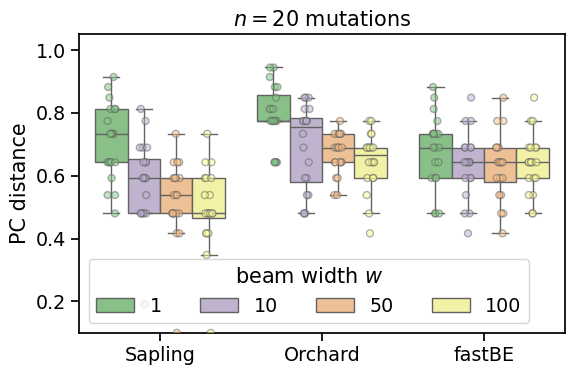

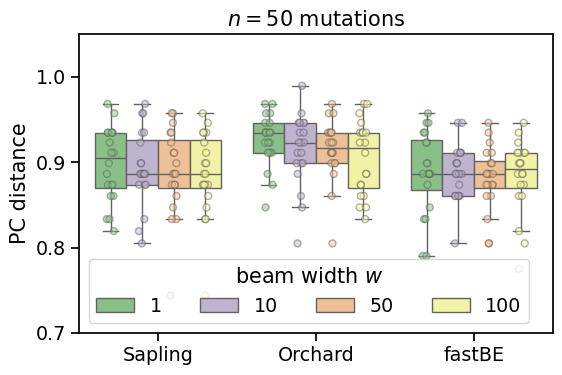

In [86]:
for n in [20,50]:
    df_filtered = df_full_trees_PC[(df_full_trees_PC['n'] == n) & (df_full_trees_PC['method'].isin(['sapling-small', 'orchard', 'fastbe']))]
    df_filtered = df_filtered.replace(
        {'method': {'sapling-small': 'Sapling', 'sapling-big' : 'Sapling (big)', 'orchard': 'Orchard', 'fastbe': 'fastBE'}}
    )

    fig, ax = plt.subplots(figsize=(6, 4))
    
    sns.boxplot(data=df_filtered, ax=ax, x='method', y='PC', hue='beam-width', showfliers=False, palette="Accent")
    sns.stripplot(data=df_filtered, ax=ax, x='method', y='PC', hue='beam-width', palette="Accent",
                  dodge=True, alpha=.5, linewidth=1)
    
    # Add labels and title
    ax.set_xlabel('')
    ax.set_ylabel('PC distance')
    ax.set_title('$n = %d$ mutations' % n)
    # ax.set_yscale('log')  
    # ax.set_ylim((-1e-2, 1.05))

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[:len(labels)//2], labels[:len(labels)//2], title='beam width $w$', ncols=4)

    if n == 20:
        ax.set_ylim((0.1, 1.05))
    if n == 50:
        ax.set_ylim((0.7, 1.05))
    
    
    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(f"PC_Sapling_vs_Orchard_Combined_n{n}.pdf")


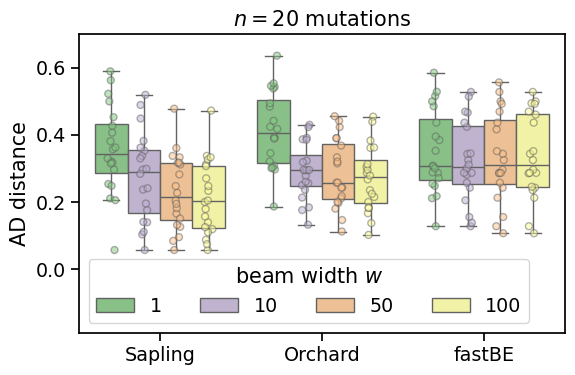

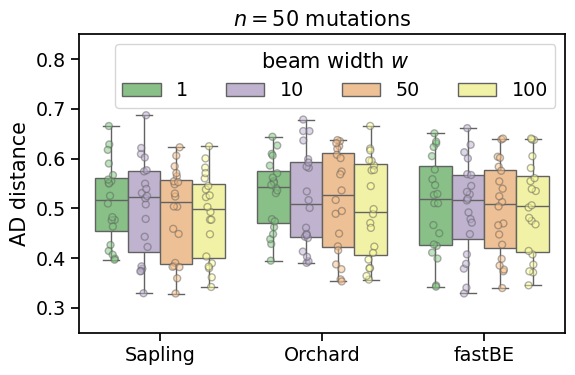

In [116]:
for n in [20,50]:
    df_filtered = df_full_trees_PC[(df_full_trees_PC['n'] == n) & (df_full_trees_PC['method'].isin(['sapling-small', 'orchard', 'fastbe']))]
    df_filtered = df_filtered.replace(
        {'method': {'sapling-small': 'Sapling', 'sapling-big' : 'Sapling (big)', 'orchard': 'Orchard', 'fastbe': 'fastBE'}}
    )

    fig, ax = plt.subplots(figsize=(6, 4))
    
    sns.boxplot(data=df_filtered, ax=ax, x='method', y='AD', hue='beam-width', showfliers=False, palette="Accent")
    sns.stripplot(data=df_filtered, ax=ax, x='method', y='AD', hue='beam-width', palette="Accent",
                  dodge=True, alpha=.5, linewidth=1)
    
    # Add labels and title
    ax.set_xlabel('')
    ax.set_ylabel('AD distance')
    ax.set_title('$n = %d$ mutations' % n)
    # ax.set_yscale('log')  
    # ax.set_ylim((-1e-2, 1.05))

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[:len(labels)//2], labels[:len(labels)//2], title='beam width $w$', ncols=4)

    if n == 20:
        ax.set_ylim((-0.19, 0.7))
    if n == 50:
        ax.set_ylim((0.25, .85))
    
    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(f"AD_Sapling_vs_Orchard_Combined_n{n}.pdf")

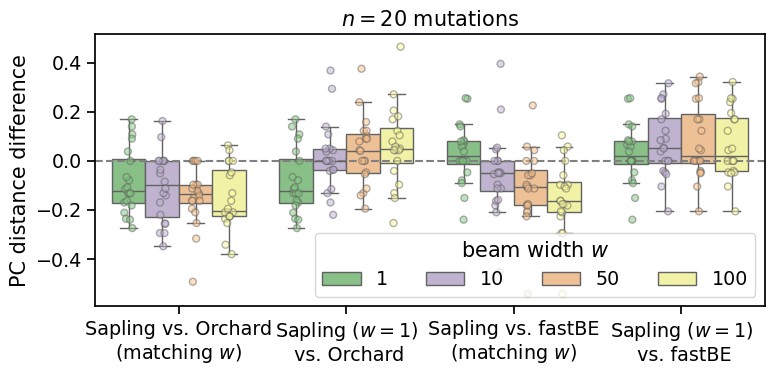

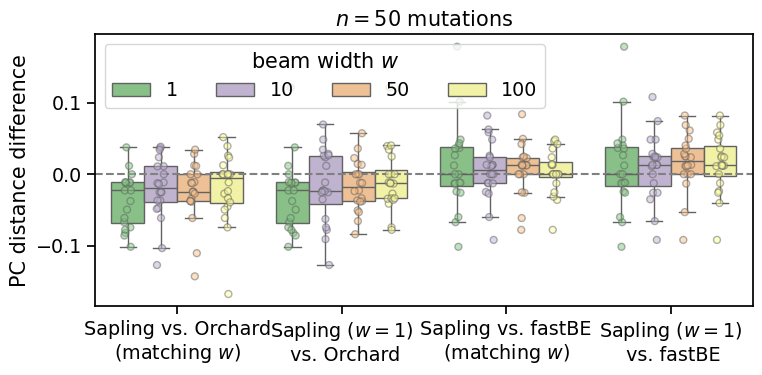

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

for n in [20, 50]:
    # Filter the dataframe for the current value of n
    df = df_full_trees_PC[(df_full_trees_PC["n"] == n)]
    
    # ---- Sapling vs Orchard ----
    # Step 1: Filter rows where method is 'sapling-small' and beam-width == 1
    sapling_small_beam1 = df[(df['method'] == 'sapling-small') & (df['beam-width'] == 1)]
    
    # Step 2: Filter rows where method is 'orchard'
    orchard_methods = df[df['method'] == 'orchard']
    
    # Step 3: Merge the two dataframes on 'instance' for the first comparison
    merged_beam1_vs_orchard = pd.merge(
        sapling_small_beam1[['instance', 'PC']],
        orchard_methods[['instance', 'beam-width', 'PC']],
        on='instance',
        suffixes=('_sapling_small_beam1', '_orchard')
    )
    
    # Step 4: Compute the PC difference for the first comparison
    merged_beam1_vs_orchard['PC_diff'] = (
        merged_beam1_vs_orchard['PC_sapling_small_beam1'] -
        merged_beam1_vs_orchard['PC_orchard']
    )
    merged_beam1_vs_orchard['comparison'] = 'Sapling ($w=1$)\n vs. Orchard'
    
    # Step 5: Compare sapling-small vs. orchard with matching beamwidths
    sapling_small_all_beamwidths = df[df['method'] == 'sapling-small']
    orchard_all_beamwidths = df[df['method'] == 'orchard']
    
    merged_matching_beamwidths_orchard = pd.merge(
        sapling_small_all_beamwidths[['instance', 'beam-width', 'PC']],
        orchard_all_beamwidths[['instance', 'beam-width', 'PC']],
        on=['instance', 'beam-width'],
        suffixes=('_sapling_small', '_orchard')
    )
    
    merged_matching_beamwidths_orchard['PC_diff'] = (
        merged_matching_beamwidths_orchard['PC_sapling_small'] -
        merged_matching_beamwidths_orchard['PC_orchard']
    )
    merged_matching_beamwidths_orchard['comparison'] = 'Sapling vs. Orchard\n(matching $w$)'
    
    # ---- Sapling vs fastBE ----
    fastbe_methods = df[df['method'] == 'fastbe']
    
    # Sapling (w = 1) vs fastBE (all k / beam-widths)
    merged_beam1_vs_fastbe = pd.merge(
        sapling_small_beam1[['instance', 'PC']],
        fastbe_methods[['instance', 'beam-width', 'PC']],
        on='instance',
        suffixes=('_sapling_small_beam1', '_fastbe')
    )
    merged_beam1_vs_fastbe['PC_diff'] = (
        merged_beam1_vs_fastbe['PC_sapling_small_beam1'] -
        merged_beam1_vs_fastbe['PC_fastbe']
    )
    merged_beam1_vs_fastbe['comparison'] = 'Sapling ($w=1$)\n vs. fastBE'
    
    # Sapling vs fastBE with matching beam-widths
    fastbe_all_beamwidths = fastbe_methods
    
    merged_matching_beamwidths_fastbe = pd.merge(
        sapling_small_all_beamwidths[['instance', 'beam-width', 'PC']],
        fastbe_all_beamwidths[['instance', 'beam-width', 'PC']],
        on=['instance', 'beam-width'],
        suffixes=('_sapling_small', '_fastbe')
    )
    merged_matching_beamwidths_fastbe['PC_diff'] = (
        merged_matching_beamwidths_fastbe['PC_sapling_small'] -
        merged_matching_beamwidths_fastbe['PC_fastbe']
    )
    merged_matching_beamwidths_fastbe['comparison'] = 'Sapling vs. fastBE\n(matching $w$)'
    
    # ---- Combine all four comparisons ----
    combined = pd.concat(
        [
            merged_matching_beamwidths_orchard,
            merged_beam1_vs_orchard,
            merged_matching_beamwidths_fastbe,
            merged_beam1_vs_fastbe,
        ],
        ignore_index=True
    )
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 4))
    
    sns.boxplot(
        data=combined,
        ax=ax,
        x="comparison",
        y='PC_diff',
        hue='beam-width',
        showfliers=False,
        palette="Accent"
    )
    sns.stripplot(
        data=combined,
        ax=ax,
        x="comparison",
        y='PC_diff',
        hue='beam-width',
        dodge=True,
        alpha=.5,
        linewidth=1,
        palette="Accent"
    )
    
    # Add labels and title
    plt.xlabel('')
    plt.ylabel('PC distance difference')
    plt.title(f'$n = {n}$ mutations')
    plt.axhline(y=0, linestyle='--', color='gray')
    
    # Adjust legend (remove duplicate entries)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(
        handles[:len(labels)//2],
        labels[:len(labels)//2],
        title='beam width $w$',
        ncols=4
    )
    
    # Optional y-lims if you want them back:
    # if n == 20:
    #     ax.set_ylim((-0.9, 0.9))
    # if n == 50:
    #     ax.set_ylim((-0.25, .25))
    
    plt.tight_layout()
    plt.savefig(f"PC_Diff_Sapling_vs_Orchard_FastBE_Combined_n{n}.pdf")

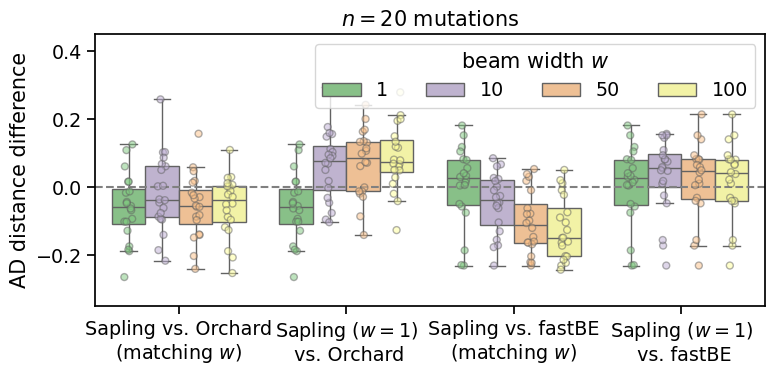

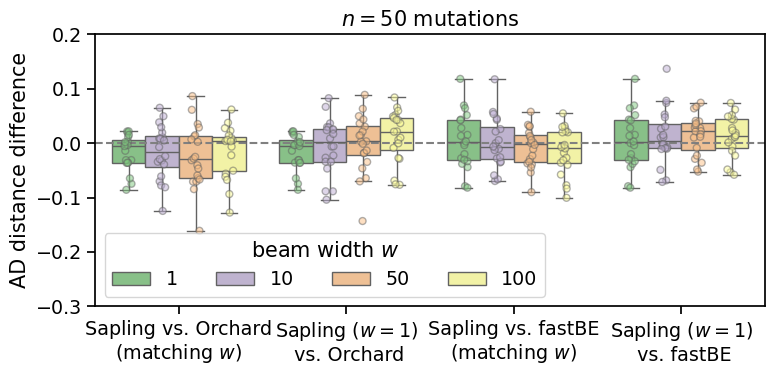

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

for n in [20, 50]:
    # Filter the dataframe for the current value of n
    df = df_full_trees_PC[(df_full_trees_PC["n"] == n)]
    
    # ---- Sapling vs Orchard ----
    # Step 1: Sapling-small w = 1
    sapling_small_beam1 = df[(df['method'] == 'sapling-small') & (df['beam-width'] == 1)]
    
    # Step 2: Orchard
    orchard_methods = df[df['method'] == 'orchard']
    
    # Step 3: Sapling (w=1) vs Orchard (all w)
    merged_beam1_vs_orchard = pd.merge(
        sapling_small_beam1[['instance', 'AD']],
        orchard_methods[['instance', 'beam-width', 'AD']],
        on='instance',
        suffixes=('_sapling_small_beam1', '_orchard')
    )
    
    merged_beam1_vs_orchard['AD_diff'] = (
        merged_beam1_vs_orchard['AD_sapling_small_beam1'] -
        merged_beam1_vs_orchard['AD_orchard']
    )
    merged_beam1_vs_orchard['comparison'] = 'Sapling ($w=1$)\n vs. Orchard'
    
    # Step 4: Sapling vs Orchard (matching w)
    sapling_small_all_beamwidths = df[df['method'] == 'sapling-small']
    orchard_all_beamwidths     = df[df['method'] == 'orchard']
    
    merged_matching_beamwidths_orchard = pd.merge(
        sapling_small_all_beamwidths[['instance', 'beam-width', 'AD']],
        orchard_all_beamwidths[['instance', 'beam-width', 'AD']],
        on=['instance', 'beam-width'],
        suffixes=('_sapling_small', '_orchard')
    )
    
    merged_matching_beamwidths_orchard['AD_diff'] = (
        merged_matching_beamwidths_orchard['AD_sapling_small'] -
        merged_matching_beamwidths_orchard['AD_orchard']
    )
    merged_matching_beamwidths_orchard['comparison'] = 'Sapling vs. Orchard\n(matching $w$)'
    
    # ---- Sapling vs fastBE ----
    fastbe_methods = df[df['method'] == 'fastbe']
    
    # Sapling (w=1) vs fastBE (all w)
    merged_beam1_vs_fastbe = pd.merge(
        sapling_small_beam1[['instance', 'AD']],
        fastbe_methods[['instance', 'beam-width', 'AD']],
        on='instance',
        suffixes=('_sapling_small_beam1', '_fastbe')
    )
    
    merged_beam1_vs_fastbe['AD_diff'] = (
        merged_beam1_vs_fastbe['AD_sapling_small_beam1'] -
        merged_beam1_vs_fastbe['AD_fastbe']
    )
    merged_beam1_vs_fastbe['comparison'] = 'Sapling ($w=1$)\n vs. fastBE'
    
    # Sapling vs fastBE (matching w)
    merged_matching_beamwidths_fastbe = pd.merge(
        sapling_small_all_beamwidths[['instance', 'beam-width', 'AD']],
        fastbe_methods[['instance', 'beam-width', 'AD']],
        on=['instance', 'beam-width'],
        suffixes=('_sapling_small', '_fastbe')
    )
    
    merged_matching_beamwidths_fastbe['AD_diff'] = (
        merged_matching_beamwidths_fastbe['AD_sapling_small'] -
        merged_matching_beamwidths_fastbe['AD_fastbe']
    )
    merged_matching_beamwidths_fastbe['comparison'] = 'Sapling vs. fastBE\n(matching $w$)'
    
    # ---- Combine everything ----
    combined = pd.concat([
        merged_matching_beamwidths_orchard,
        merged_beam1_vs_orchard,
        merged_matching_beamwidths_fastbe,
        merged_beam1_vs_fastbe
    ])
    
    # ---- Plot ----
    fig, ax = plt.subplots(figsize=(8, 4))
    
    sns.boxplot(
        data=combined, ax=ax,
        x="comparison", y='AD_diff',
        hue='beam-width',
        showfliers=False, palette="Accent"
    )
    
    sns.stripplot(
        data=combined, ax=ax,
        x="comparison", y='AD_diff',
        hue='beam-width',
        dodge=True, alpha=.5, linewidth=1,
        palette="Accent"
    )
    
    plt.xlabel('')
    plt.ylabel('AD distance difference')
    plt.title(f'$n = {n}$ mutations')
    plt.axhline(y=0, linestyle='--', color='gray')
    
    # Fix duplicate legend entries (boxplot + stripplot)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(
        handles[:len(labels)//2],
        labels[:len(labels)//2],
        title='beam width $w$',
        ncols=4
    )
    
    # Keep your y-limits
    if n == 20:
        ax.set_ylim((-0.35, 0.45))
    if n == 50:
        ax.set_ylim((-0.3, .2))
    
    plt.tight_layout()
    plt.savefig(f"AD_Diff_Sapling_vs_Orchard_FastBE_Combined_n{n}.pdf")
    # plt.close()

In [46]:
df_full_trees_PC[(df_full_trees_PC['method'] == 'orchard') & (df_full_trees_PC['beam-width'] == 1) & (df_full_trees_PC['n'] == 20)]['PC'].median()

np.float64(0.7741935483870968)

In [67]:
df_full_trees_PC[(df_full_trees_PC['method'] == 'fastbe') & (df_full_trees_PC['beam-width'] == 1) & (df_full_trees_PC['n'] == 50)]['PC'].median()

np.float64(0.8863636363636364)

In [64]:
df_full_trees_PC[(df_full_trees_PC['method'] == 'fastbe') & (df_full_trees_PC['beam-width'] == 1) & (df_full_trees_PC['n'] == 20)]['AD'].median()

np.float64(0.3071467839472237)

In [56]:
df_full_trees_PC

,n,beam-width,instance,method,PC,recall,AD
0,20,1,n20_m10_s1,sapling-small,0.733333,0.421053,0.253731
1,20,1,n20_m10_s1,orchard,0.812500,0.315789,0.308271
2,20,1,n20_m10_s1,fastbe,0.812500,0.315789,0.248175
3,20,10,n20_m10_s1,sapling-small,0.733333,0.421053,0.179688
4,20,10,n20_m10_s1,orchard,0.774194,0.368421,0.301587
...,...,...,...,...,...,...,...
475,50,50,n50_m10_s20,orchard,0.968421,0.061224,0.461053
476,50,50,n50_m10_s20,fastbe,0.804878,0.326531,0.427126
477,50,100,n50_m10_s20,sapling-small,0.847059,0.265306,0.400000
478,50,100,n50_m10_s20,orchard,0.911111,0.163265,0.405640


In [101]:
# Loop through varying mutation counts (n) and beam widths (w)
for n in [20, 50]:
    for w in [1, 10, 50, 100]:
        
        # Helper to get medians for a specific method from the single dataframe
        def get_vals(method_name):
            subset = df_full_trees_PC[
                (df_full_trees_PC['method'] == method_name) & 
                (df_full_trees_PC['beam-width'] == w) & 
                (df_full_trees_PC['n'] == n)
            ]
            # Returns a tuple: (PC median, AD median)
            return subset['PC'].median(), subset['AD'].median(), subset['CASet'].median(), subset['DISC'].median()

        # Extract values for each method
        sap_pc, sap_ad, sap_caset, sap_disc = get_vals('sapling-small')
        orch_pc, orch_ad, orch_caset, orch_disc = get_vals('orchard')
        fast_pc, fast_ad, fast_caset, fast_disc = get_vals('fastbe')

        # Print the formatted LaTeX string
        print(
            f"For example, for beam width $w={w}$ and $n={n}$ mutations, "
            f"Sapling achieved a median PC (AD; CASet; DISC) distance of "
            f"${sap_pc:.2f}$ (${sap_ad:.2f}$; ${sap_caset:.2f}$; ${sap_disc:.2f}$) vs.\\ "
            f"${orch_pc:.2f}$ (${orch_ad:.2f}$; ${orch_caset:.2f}$; ${orch_disc:.2f}$) for Orchard, and "
            f"${fast_pc:.2f}$ (${fast_ad:.2f}$; ${fast_caset:.2f}$; ${fast_disc:.2f}$) for fastBE."
        )

For example, for beam width $w=1$ and $n=20$ mutations, Sapling achieved a median PC (AD; CASet; DISC) distance of $0.73$ ($0.34$; $0.28$; $0.45$) vs.\ $0.77$ ($0.41$; $0.33$; $0.51$) for Orchard, and $0.69$ ($0.31$; $0.25$; $0.43$) for fastBE.
For example, for beam width $w=10$ and $n=20$ mutations, Sapling achieved a median PC (AD; CASet; DISC) distance of $0.59$ ($0.29$; $0.19$; $0.34$) vs.\ $0.75$ ($0.29$; $0.23$; $0.39$) for Orchard, and $0.64$ ($0.31$; $0.22$; $0.40$) for fastBE.
For example, for beam width $w=50$ and $n=20$ mutations, Sapling achieved a median PC (AD; CASet; DISC) distance of $0.54$ ($0.22$; $0.17$; $0.32$) vs.\ $0.69$ ($0.26$; $0.20$; $0.39$) for Orchard, and $0.64$ ($0.31$; $0.24$; $0.40$) for fastBE.
For example, for beam width $w=100$ and $n=20$ mutations, Sapling achieved a median PC (AD; CASet; DISC) distance of $0.48$ ($0.20$; $0.17$; $0.30$) vs.\ $0.67$ ($0.27$; $0.17$; $0.37$) for Orchard, and $0.64$ ($0.31$; $0.24$; $0.40$) for fastBE.
For example, for

In [104]:
import pandas as pd

# Define the methods and their display names
methods_map = {
    'sapling-small': 'Sapling',
    'orchard': 'Orchard',
    'fastbe': 'fastBE' # Ensure this matches your dataframe value exactly
}

# Start the LaTeX string
latex_output = []
latex_output.append(r"\begin{table}[t]")
latex_output.append(r"    \centering")
latex_output.append(r"    \caption{Median PC, AD, CASet, and DISC distances for varying mutations ($n$) and beam widths ($w$). \textbf{Bold} indicates the best (lowest) value.}")
latex_output.append(r"    \label{tab:metrics_comparison}")
latex_output.append(r"    \setlength{\tabcolsep}{5pt} % Adjust column padding")
latex_output.append(r"    \begin{tabular}{cc l cccc}")
latex_output.append(r"    \toprule")
latex_output.append(r"    \multirow{2}{*}{$n$} & \multirow{2}{*}{$w$} & \multirow{2}{*}{Method} & \multicolumn{4}{c}{Median Distance} \\")
latex_output.append(r"    \cmidrule(l){4-7}")
latex_output.append(r"     & & & PC & AD & CASet & DISC \\")
latex_output.append(r"    \midrule")

# Helper to format numbers and bold the best one
def fmt(val, best_val):
    if pd.isna(val):
        return "-"
    s = f"{val:.2f}"
    # Use a small epsilon for float comparison
    if abs(val - best_val) < 1e-6:
        return f"\\textbf{{{s}}}"
    return s

# Loop through parameters
for n_idx, n in enumerate([20, 50]):
    # Add a midrule between different n blocks (except the first)
    if n_idx > 0:
        latex_output.append(r"    \midrule")
        
    for w_idx, w in enumerate([1, 10, 50, 100]):
        
        # 1. Collect data for all methods first (to find minimums for bolding)
        data_cache = {}
        for m_key in methods_map.keys():
            subset = df_full_trees_PC[
                (df_full_trees_PC['method'] == m_key) & 
                (df_full_trees_PC['beam-width'] == w) & 
                (df_full_trees_PC['n'] == n)
            ]
            
            # Store medians if data exists
            if not subset.empty:
                data_cache[m_key] = {
                    'PC': subset['PC'].median(),
                    'AD': subset['AD'].median(),
                    'CASet': subset['CASet'].median(),
                    'DISC': subset['DISC'].median()
                }
            else:
                data_cache[m_key] = {k: float('inf') for k in ['PC', 'AD', 'CASet', 'DISC']}

        # 2. Find best (min) values for this specific (n, w) group
        best_scores = {
            'PC': min(d['PC'] for d in data_cache.values()),
            'AD': min(d['AD'] for d in data_cache.values()),
            'CASet': min(d['CASet'] for d in data_cache.values()),
            'DISC': min(d['DISC'] for d in data_cache.values())
        }

        # 3. Print Rows
        # We use Multirow for the first column (n) and second column (w)
        # Only print n on the very first row of the block
        
        first_method = True
        for m_key, m_name in methods_map.items():
            vals = data_cache[m_key]
            
            # Prepare row strings
            n_str = f"\\multirow{{12}}{{*}}{{{n}}}" if (w_idx == 0 and first_method) else ""
            w_str = f"\\multirow{{3}}{{*}}{{{w}}}" if first_method else ""
            
            # Format metrics with bolding logic
            pc_str = fmt(vals['PC'], best_scores['PC'])
            ad_str = fmt(vals['AD'], best_scores['AD'])
            ca_str = fmt(vals['CASet'], best_scores['CASet'])
            di_str = fmt(vals['DISC'], best_scores['DISC'])
            
            latex_output.append(
                f"    {n_str} & {w_str} & {m_name} & {pc_str} & {ad_str} & {ca_str} & {di_str} \\\\"
            )
            first_method = False
            
        # Add a small vertical space between beam width groups (optional)
        if w != 100: 
            latex_output.append(r"    \cmidrule(l){2-7}")

latex_output.append(r"    \bottomrule")
latex_output.append(r"    \end{tabular}")
latex_output.append(r"\end{table}")

# Join and print
print("\n".join(latex_output))

\begin{table}[t]
    \centering
    \caption{Median PC, AD, CASet, and DISC distances for varying mutations ($n$) and beam widths ($w$). \textbf{Bold} indicates the best (lowest) value.}
    \label{tab:metrics_comparison}
    \setlength{\tabcolsep}{5pt} % Adjust column padding
    \begin{tabular}{cc l cccc}
    \toprule
    \multirow{2}{*}{$n$} & \multirow{2}{*}{$w$} & \multirow{2}{*}{Method} & \multicolumn{4}{c}{Median Distance} \\
    \cmidrule(l){4-7}
     & & & PC & AD & CASet & DISC \\
    \midrule
    \multirow{12}{*}{20} & \multirow{3}{*}{1} & Sapling & 0.73 & 0.34 & 0.28 & 0.45 \\
     &  & Orchard & 0.77 & 0.41 & 0.33 & 0.51 \\
     &  & fastBE & \textbf{0.69} & \textbf{0.31} & \textbf{0.25} & \textbf{0.43} \\
    \cmidrule(l){2-7}
     & \multirow{3}{*}{10} & Sapling & \textbf{0.59} & \textbf{0.29} & \textbf{0.19} & \textbf{0.34} \\
     &  & Orchard & 0.75 & 0.29 & 0.23 & 0.39 \\
     &  & fastBE & 0.64 & 0.31 & 0.22 & 0.40 \\
    \cmidrule(l){2-7}
     & \multirow{3}{*}{50}

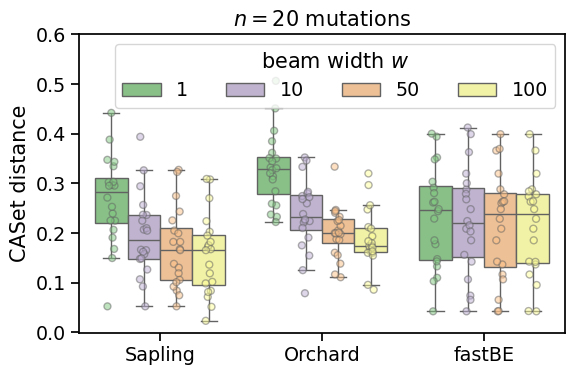

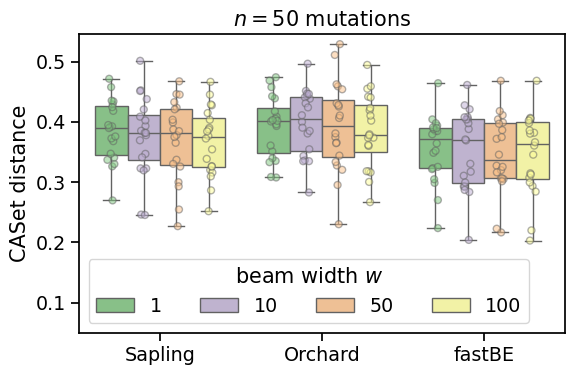

In [111]:
for n in [20,50]:
    df_filtered = df_full_trees_PC[(df_full_trees_PC['n'] == n) & (df_full_trees_PC['method'].isin(['sapling-small', 'orchard', 'fastbe']))]
    df_filtered = df_filtered.replace(
        {'method': {'sapling-small': 'Sapling', 'sapling-big' : 'Sapling (big)', 'orchard': 'Orchard', 'fastbe': 'fastBE'}}
    )

    fig, ax = plt.subplots(figsize=(6, 4))
    
    sns.boxplot(data=df_filtered, ax=ax, x='method', y='CASet', hue='beam-width', showfliers=False, palette="Accent")
    sns.stripplot(data=df_filtered, ax=ax, x='method', y='CASet', hue='beam-width', palette="Accent",
                  dodge=True, alpha=.5, linewidth=1)
    
    # Add labels and title
    ax.set_xlabel('')
    ax.set_ylabel('CASet distance')
    ax.set_title('$n = %d$ mutations' % n)
    # ax.set_yscale('log')  
    # ax.set_ylim((-1e-2, 1.05))

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[:len(labels)//2], labels[:len(labels)//2], title='beam width $w$', ncols=4)

    if n == 20:
        ax.set_ylim((None, 0.6))
    if n == 50:
        ax.set_ylim((0.05, None))
    
    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(f"CASet_Sapling_vs_Orchard_Combined_n{n}.pdf")

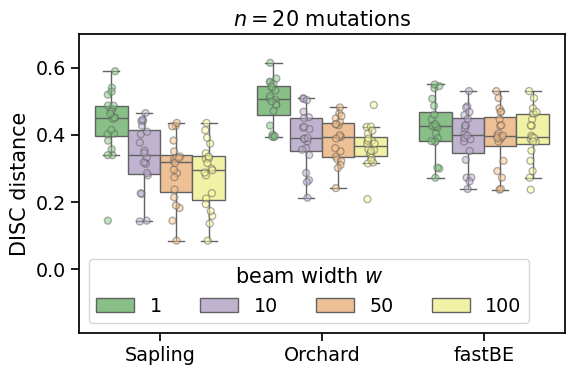

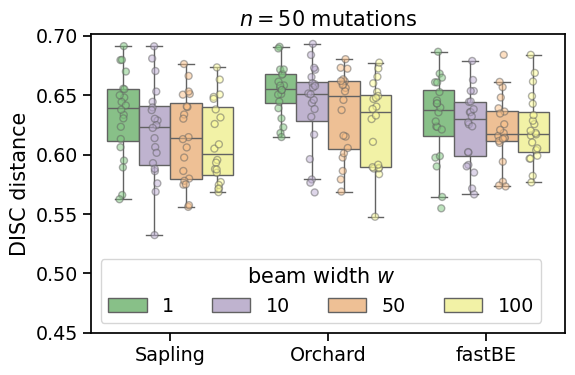

In [115]:
for n in [20,50]:
    df_filtered = df_full_trees_PC[(df_full_trees_PC['n'] == n) & (df_full_trees_PC['method'].isin(['sapling-small', 'orchard', 'fastbe']))]
    df_filtered = df_filtered.replace(
        {'method': {'sapling-small': 'Sapling', 'sapling-big' : 'Sapling (big)', 'orchard': 'Orchard', 'fastbe': 'fastBE'}}
    )

    fig, ax = plt.subplots(figsize=(6, 4))
    
    sns.boxplot(data=df_filtered, ax=ax, x='method', y='DISC', hue='beam-width', showfliers=False, palette="Accent")
    sns.stripplot(data=df_filtered, ax=ax, x='method', y='DISC', hue='beam-width', palette="Accent",
                  dodge=True, alpha=.5, linewidth=1)
    
    # Add labels and title
    ax.set_xlabel('')
    ax.set_ylabel('DISC distance')
    ax.set_title('$n = %d$ mutations' % n)
    # ax.set_yscale('log')  
    # ax.set_ylim((-1e-2, 1.05))

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[:len(labels)//2], labels[:len(labels)//2], title='beam width $w$', ncols=4)

    if n == 20:
        ax.set_ylim((-0.19, 0.7))
    if n == 50:
        ax.set_ylim((0.45, None))
    
    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(f"DISC_Sapling_vs_Orchard_Combined_n{n}.pdf")

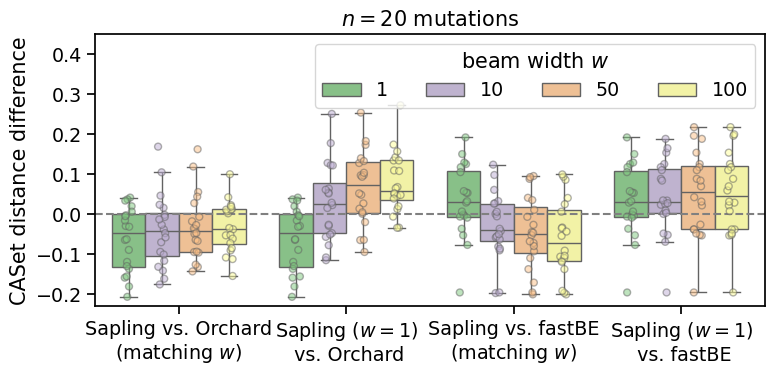

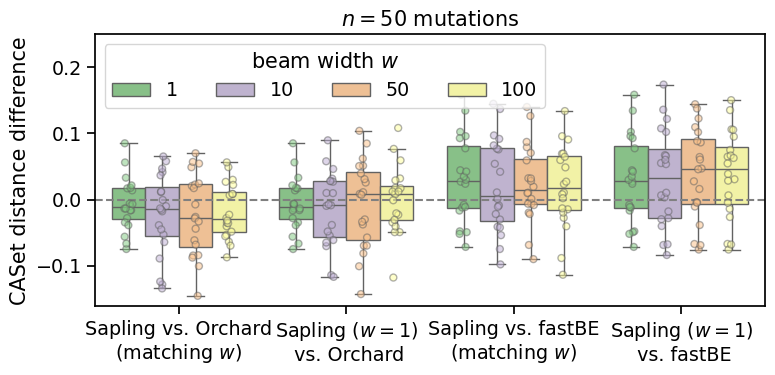

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

for n in [20, 50]:
    # Filter the dataframe for the current value of n
    df = df_full_trees_PC[(df_full_trees_PC["n"] == n)]
    
    # ---- Sapling vs Orchard ----
    # Step 1: Filter rows where method is 'sapling-small' and beam-width == 1
    sapling_small_beam1 = df[(df['method'] == 'sapling-small') & (df['beam-width'] == 1)]
    
    # Step 2: Filter rows where method is 'orchard'
    orchard_methods = df[df['method'] == 'orchard']
    
    # Step 3: Merge the two dataframes on 'instance' for the first comparison
    merged_beam1_vs_orchard = pd.merge(
        sapling_small_beam1[['instance', 'CASet']],
        orchard_methods[['instance', 'beam-width', 'CASet']],
        on='instance',
        suffixes=('_sapling_small_beam1', '_orchard')
    )
    
    # Step 4: Compute the PC difference for the first comparison
    merged_beam1_vs_orchard['CASet_diff'] = (
        merged_beam1_vs_orchard['CASet_sapling_small_beam1'] -
        merged_beam1_vs_orchard['CASet_orchard']
    )
    merged_beam1_vs_orchard['comparison'] = 'Sapling ($w=1$)\n vs. Orchard'
    
    # Step 5: Compare sapling-small vs. orchard with matching beamwidths
    sapling_small_all_beamwidths = df[df['method'] == 'sapling-small']
    orchard_all_beamwidths = df[df['method'] == 'orchard']
    
    merged_matching_beamwidths_orchard = pd.merge(
        sapling_small_all_beamwidths[['instance', 'beam-width', 'CASet']],
        orchard_all_beamwidths[['instance', 'beam-width', 'CASet']],
        on=['instance', 'beam-width'],
        suffixes=('_sapling_small', '_orchard')
    )
    
    merged_matching_beamwidths_orchard['CASet_diff'] = (
        merged_matching_beamwidths_orchard['CASet_sapling_small'] -
        merged_matching_beamwidths_orchard['CASet_orchard']
    )
    merged_matching_beamwidths_orchard['comparison'] = 'Sapling vs. Orchard\n(matching $w$)'
    
    # ---- Sapling vs fastBE ----
    fastbe_methods = df[df['method'] == 'fastbe']
    
    # Sapling (w = 1) vs fastBE (all k / beam-widths)
    merged_beam1_vs_fastbe = pd.merge(
        sapling_small_beam1[['instance', 'CASet']],
        fastbe_methods[['instance', 'beam-width', 'CASet']],
        on='instance',
        suffixes=('_sapling_small_beam1', '_fastbe')
    )
    merged_beam1_vs_fastbe['CASet_diff'] = (
        merged_beam1_vs_fastbe['CASet_sapling_small_beam1'] -
        merged_beam1_vs_fastbe['CASet_fastbe']
    )
    merged_beam1_vs_fastbe['comparison'] = 'Sapling ($w=1$)\n vs. fastBE'
    
    # Sapling vs fastBE with matching beam-widths
    fastbe_all_beamwidths = fastbe_methods
    
    merged_matching_beamwidths_fastbe = pd.merge(
        sapling_small_all_beamwidths[['instance', 'beam-width', 'CASet']],
        fastbe_all_beamwidths[['instance', 'beam-width', 'CASet']],
        on=['instance', 'beam-width'],
        suffixes=('_sapling_small', '_fastbe')
    )
    merged_matching_beamwidths_fastbe['CASet_diff'] = (
        merged_matching_beamwidths_fastbe['CASet_sapling_small'] -
        merged_matching_beamwidths_fastbe['CASet_fastbe']
    )
    merged_matching_beamwidths_fastbe['comparison'] = 'Sapling vs. fastBE\n(matching $w$)'
    
    # ---- Combine all four comparisons ----
    combined = pd.concat(
        [
            merged_matching_beamwidths_orchard,
            merged_beam1_vs_orchard,
            merged_matching_beamwidths_fastbe,
            merged_beam1_vs_fastbe,
        ],
        ignore_index=True
    )
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 4))
    
    sns.boxplot(
        data=combined,
        ax=ax,
        x="comparison",
        y='CASet_diff',
        hue='beam-width',
        showfliers=False,
        palette="Accent"
    )
    sns.stripplot(
        data=combined,
        ax=ax,
        x="comparison",
        y='CASet_diff',
        hue='beam-width',
        dodge=True,
        alpha=.5,
        linewidth=1,
        palette="Accent"
    )
    
    # Add labels and title
    plt.xlabel('')
    plt.ylabel('CASet distance difference')
    plt.title(f'$n = {n}$ mutations')
    plt.axhline(y=0, linestyle='--', color='gray')
    
    # Adjust legend (remove duplicate entries)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(
        handles[:len(labels)//2],
        labels[:len(labels)//2],
        title='beam width $w$',
        ncols=4
    )
    
    # Optional y-lims if you want them back:
    if n == 20:
        ax.set_ylim((None, 0.45))
    if n == 50:
        ax.set_ylim((None, 0.25))
    
    plt.tight_layout()
    plt.savefig(f"CASet_Diff_Sapling_vs_Orchard_FastBE_Combined_n{n}.pdf")

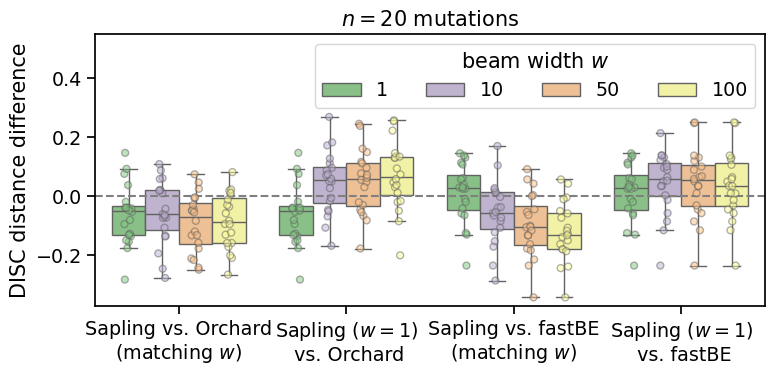

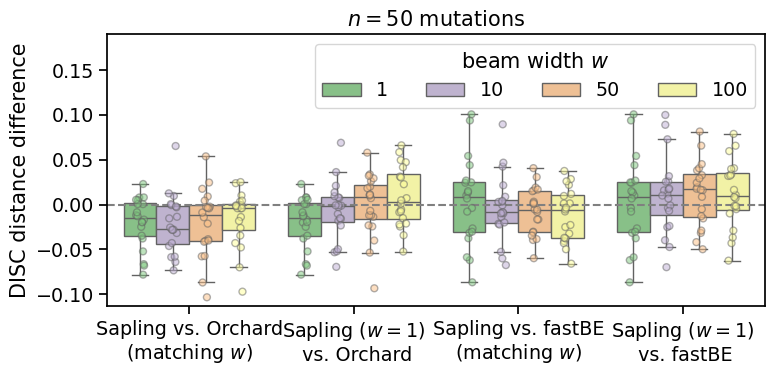

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

for n in [20, 50]:
    # Filter the dataframe for the current value of n
    df = df_full_trees_PC[(df_full_trees_PC["n"] == n)]
    
    # ---- Sapling vs Orchard ----
    # Step 1: Filter rows where method is 'sapling-small' and beam-width == 1
    sapling_small_beam1 = df[(df['method'] == 'sapling-small') & (df['beam-width'] == 1)]
    
    # Step 2: Filter rows where method is 'orchard'
    orchard_methods = df[df['method'] == 'orchard']
    
    # Step 3: Merge the two dataframes on 'instance' for the first comparison
    merged_beam1_vs_orchard = pd.merge(
        sapling_small_beam1[['instance', 'DISC']],
        orchard_methods[['instance', 'beam-width', 'DISC']],
        on='instance',
        suffixes=('_sapling_small_beam1', '_orchard')
    )
    
    # Step 4: Compute the PC difference for the first comparison
    merged_beam1_vs_orchard['DISC_diff'] = (
        merged_beam1_vs_orchard['DISC_sapling_small_beam1'] -
        merged_beam1_vs_orchard['DISC_orchard']
    )
    merged_beam1_vs_orchard['comparison'] = 'Sapling ($w=1$)\n vs. Orchard'
    
    # Step 5: Compare sapling-small vs. orchard with matching beamwidths
    sapling_small_all_beamwidths = df[df['method'] == 'sapling-small']
    orchard_all_beamwidths = df[df['method'] == 'orchard']
    
    merged_matching_beamwidths_orchard = pd.merge(
        sapling_small_all_beamwidths[['instance', 'beam-width', 'DISC']],
        orchard_all_beamwidths[['instance', 'beam-width', 'DISC']],
        on=['instance', 'beam-width'],
        suffixes=('_sapling_small', '_orchard')
    )
    
    merged_matching_beamwidths_orchard['DISC_diff'] = (
        merged_matching_beamwidths_orchard['DISC_sapling_small'] -
        merged_matching_beamwidths_orchard['DISC_orchard']
    )
    merged_matching_beamwidths_orchard['comparison'] = 'Sapling vs. Orchard\n(matching $w$)'
    
    # ---- Sapling vs fastBE ----
    fastbe_methods = df[df['method'] == 'fastbe']
    
    # Sapling (w = 1) vs fastBE (all k / beam-widths)
    merged_beam1_vs_fastbe = pd.merge(
        sapling_small_beam1[['instance', 'DISC']],
        fastbe_methods[['instance', 'beam-width', 'DISC']],
        on='instance',
        suffixes=('_sapling_small_beam1', '_fastbe')
    )
    merged_beam1_vs_fastbe['DISC_diff'] = (
        merged_beam1_vs_fastbe['DISC_sapling_small_beam1'] -
        merged_beam1_vs_fastbe['DISC_fastbe']
    )
    merged_beam1_vs_fastbe['comparison'] = 'Sapling ($w=1$)\n vs. fastBE'
    
    # Sapling vs fastBE with matching beam-widths
    fastbe_all_beamwidths = fastbe_methods
    
    merged_matching_beamwidths_fastbe = pd.merge(
        sapling_small_all_beamwidths[['instance', 'beam-width', 'DISC']],
        fastbe_all_beamwidths[['instance', 'beam-width', 'DISC']],
        on=['instance', 'beam-width'],
        suffixes=('_sapling_small', '_fastbe')
    )
    merged_matching_beamwidths_fastbe['DISC_diff'] = (
        merged_matching_beamwidths_fastbe['DISC_sapling_small'] -
        merged_matching_beamwidths_fastbe['DISC_fastbe']
    )
    merged_matching_beamwidths_fastbe['comparison'] = 'Sapling vs. fastBE\n(matching $w$)'
    
    # ---- Combine all four comparisons ----
    combined = pd.concat(
        [
            merged_matching_beamwidths_orchard,
            merged_beam1_vs_orchard,
            merged_matching_beamwidths_fastbe,
            merged_beam1_vs_fastbe,
        ],
        ignore_index=True
    )
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 4))
    
    sns.boxplot(
        data=combined,
        ax=ax,
        x="comparison",
        y='DISC_diff',
        hue='beam-width',
        showfliers=False,
        palette="Accent"
    )
    sns.stripplot(
        data=combined,
        ax=ax,
        x="comparison",
        y='DISC_diff',
        hue='beam-width',
        dodge=True,
        alpha=.5,
        linewidth=1,
        palette="Accent"
    )
    
    # Add labels and title
    plt.xlabel('')
    plt.ylabel('DISC distance difference')
    plt.title(f'$n = {n}$ mutations')
    plt.axhline(y=0, linestyle='--', color='gray')
    
    # Adjust legend (remove duplicate entries)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(
        handles[:len(labels)//2],
        labels[:len(labels)//2],
        title='beam width $w$',
        ncols=4
    )
    
    # Optional y-lims if you want them back:
    if n == 20:
        ax.set_ylim((None, 0.55))
    if n == 50:
        ax.set_ylim((None, 0.19))
    
    plt.tight_layout()
    plt.savefig(f"DISC_Diff_Sapling_vs_Orchard_FastBE_Combined_n{n}.pdf")